In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

**Note: While this notebook uses the UK age structure and contact matrices, the model parameters are not fitted to real data, but rather chosen ad-hoc.**

# Introduction and overview

## Model

In this notebook, we consider an SEAI5R model. Except for the lockdown protocol, the model considered here is the almost the same as in *examples/deterministic/ex11-SEAI5R-UK.ipynb*.

Differences between said notebook and the present one:
* We coarse grain the age groups, so that in this notebook we consider only 4 age groups (0-19, 20-39, 40-59, 60-79)
* For the fraction of symptomatic infectives that need to go to the hospital for these age groups we use 0.01, 0.05, 0.1, 0.1, reflecting that younger people are, on average, less affected by COVID-19.

## Protocol

We consider a protocol where a lockdown is imposed once the population in the ICU exceeds 1100 (chosen such that the following peak population in the ICU is below the ICU capacity of 4500).

We want to find the optimal times to release the lockdown in two stages:

* Stage 0: Full lockdown
* Stage 1: Release lockdown for age classes 0-19, 20-39. (Since parents of young children are often in the age group 20-39, I suppose it makes sense that either both age groups stay home, or both are released.)
* Stage 2: Release lockdown for all age classes, i.e. also for age classes 40-59 and 60-79.

During the full lockdown, the contact matrix is given by the home contact matrix $C_H$ of all age groups. For partial lockdowns the work, social, and other contact matrix elements involving all groups that are not in lockdown is added to this home contact matrix.


## Cost
We consider a cost function $C$ which is infinity if the ICU capacity is exceeded, and otherwise given by

\begin{equation}
    C = C_{lockdown} + C_{infection},
\end{equation}

where the cost of lockdown is given by

\begin{equation}
C_{lockdown} = \exp\left[ \kappa \cdot (T_1 +  T_2/5) \right],
\end{equation}

where $\kappa$ is the rate at which the cost of the lockdown increases, $T_1$ is the duration of stage 0 (full lockdown), and $T_2$ is the time of stage 1 (lockdown release for ages 0-39).

As cost of infection we choose

\begin{equation}
C_{infection} = \lambda\cdot I_{m}(t_f),
\end{equation}

where $I_m(t_f)$ is the total number of deceased at the final time of the simulation and $\lambda$ quantifies the cost of a life as compared to the cost of shutting down the economy.

## Optimisation task

We want to optimise the durations $T_1$, $T_2 >0$, i.e. we want to know how long an optimal lockdown lasts. For this, we minimise the cost function above with respect to $(T_1, T_2)$. For every evalulation of the cost function, we need to integrate the model dynamics; for this notebook, we assume deterministic dynamics.

The optimal durations of course depend on the parameters $(\kappa, \lambda)$ that appear in the cost function, and in the following we consider 

\begin{equation}
\lambda = 1,
\end{equation}

and the three values

\begin{equation}
\kappa = 10^{-6}, 10^{-3}, 1,
\end{equation}

corresponding to low economic cost, intermediate economic cost, and high economic cost.

### Load UK age structure and contact matrix

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = np.sum(Ni0[0:4])
Ni[1] = np.sum(Ni0[4:8])
Ni[2] = np.sum(Ni0[8:12])
Ni[3] = np.sum(Ni0[12:16])
N=np.sum(Ni)

In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]

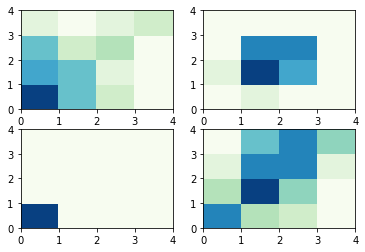

In [5]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

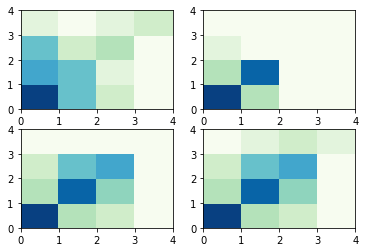

In [6]:
# Create contact matrix for age-dependent lockdown

# all locked in
C_0 = CH.copy()

# all but youngest two classes (0-19, 20-39) locked in
C_1 = CH.copy()
C_1[:2,:2] += CW[:2,:2] + CS[:2,:2] + CO[:2,:2]

# all but youngest three classes (0-19, 20-39, 40-59) locked in
C_2 = CH.copy()
C_2[:3,:3] += CW[:3,:3] + CS[:3,:3] + CO[:3,:3]

# nobody locked in
C_3 = CH + CW + CS + CO

C = CH + CW + CS + CO


fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(C_0, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(C_1, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(C_2, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(C_3, cmap=plt.cm.get_cmap('GnBu', 10));

### Define model parameters

**Note: These parameters are not fitted, but chosen ad-hoc.**

In [7]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[3] = -300            # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
hh[0] = 0.01
hh[1] = 0.05
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC



# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 1000*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

### Define function to get list of events for a given protocol

In [8]:
def get_events(protocol,time_of_first_release = 300.):
    lockdown_threshold_1, lockdown_threshold_2 = protocol
    #
    events = []
    contactMatrices = []
    # Note that for technical reasons, the event functions take a
    # vector argument "rp" instead of a tuple (S, E, A, Ia, Is, Ih, Ic, Im).
    # When defining the event functions, the following correspondence has to be used:
    # S  == rp[ :M]
    # E  == rp[M:2*M]
    # A  == rp[2*M:3*M]
    # Ia == rp[3*M:4*M]
    # Is == rp[4*M:5*M]
    # Ih == rp[5*M:6*M]
    # Ic == rp[6*M:7*M]
    # Im == rp[7*M:8*M]
    #
    # This is a dummy event which will never occur; it is used to set the initial contact matrix
    def cur_event(t,rp):
        return t + 1
    cur_event.direction = +1
    events.append(cur_event)
    contactMatrices.append( C )
    #
    # Lockdown
    lockdown_threshold_0 = 1100
    def cur_event0(t,rp):
        return np.sum(rp[6*M:7*M]) - lockdown_threshold_0
    cur_event0.direction = +1 # this means we need to pass the threshold from below for the event to happen
    events.append(cur_event0)
    contactMatrices.append( C_0 ) # everybody in lockdown
    #
    # Release age groups 0-39
    #lockdown_threshold_1 = 300
    def cur_event1(t,rp):
        #return np.sum(rp[6*M:7*M]) - lockdown_threshold_1
        return t - lockdown_threshold_1
    cur_event1.direction = +1 # this means we need to pass the threshold from above for the event to happen
    events.append(cur_event1)
    contactMatrices.append( C_1 )
    # Release all age groups
    #lockdown_threshold_2 = 290
    def cur_event2(t,rp):
        #if t < time_of_first_release:
        #    return 1.
        #else:
        #    return np.sum(rp[6*M:7*M]) - lockdown_threshold_2
        return t - lockdown_threshold_2
    cur_event2.direction = +1 # this means we need to pass the threshold from above for the event to happen
    events.append(cur_event2)
    contactMatrices.append( C_3 ) # full contact matrix
    return events, contactMatrices


events, contactMatrices = get_events(protocol=[200,300])

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni)

# Run simulation
Tf = 5*365
Nt = (Tf +1)*10

result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0 ,
                        events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                       events_repeat=False)

print(result['events_occured'])

[[70.74460829663414, 1], [200.0, 2], [300.0, 3]]


In [9]:
def plot_result(t_arr,trajs,events_occured):
    # Plot result
    #t_arr = result['t']
    #trajs = result['X'].T
    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in ICU',
                y=1.05,fontsize=25)
    ax.axhline(4500,color='orange',
               lw=3,ls='--',
               label='ICU capacity')
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)
    ax.plot(t_arr,np.sum(trajs[6*M:7*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',bbox_to_anchor=(1.4,1.02),
              framealpha=1.,
             fontsize=15)
    plt.show()
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close()


    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in ICU',
                y=1.05,fontsize=25)
    ax.axhline(4500,color='orange',
               lw=3,ls='--',
               label='ICU capacity')
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)
    ax.plot(t_arr,np.sum(trajs[6*M:7*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    #ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_xlim(0,2*365)
    ax.set_ylim(0,5500)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    #ax.legend(loc='upper right',bbox_to_anchor=(0.8,0.96),
    #          framealpha=1.,
    #         fontsize=15)
    plt.show()
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close()




    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in hospital',
                y=1.05,fontsize=25)
    #ax.axhline(4500,color='orange',
    #           lw=3,ls='--',
    #           label='ICU capacity')
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)
    ax.plot(t_arr,np.sum(trajs[5*M:6*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    #ax.set_ylim(0,5500)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    #ax.legend(loc='upper right',bbox_to_anchor=(0.8,0.96),
    #          framealpha=1.,
    #         fontsize=15)
    plt.show(fig)
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close(fig)
    
#plot_result(result['t'],result['X'].T,result['events_occured'])

### Define cost function

In [10]:
def evaluate_cost_function(t_arr,traj,protocol,events_occured,
                           prefactor_economic_cost=1.,
                           rate_economic_cost=1/7.,
                              prefactor_mortality_cost=10.):
    #global time_of_first_release
    if (np.array(protocol) < 0).any():
        return np.inf
    if protocol[0] > protocol[1]:
        return np.inf
    #
    cost = 0.
    #
    have_lockdown_start = False
    have_lockdown_end_0 = False
    have_lockdown_end_1 = False
    #
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            lockdown_start = e[0]
            have_lockdown_start = True
        elif e[1] == 2:
            lockdown_end_0 = e[0]
            have_lockdown_end_0 = True
        elif e[1] == 3:
            lockdown_end_1 = e[0]
            have_lockdown_end_1 = True
    if have_lockdown_start:
        if have_lockdown_end_0:
            cost += prefactor_economic_cost* np.exp(rate_economic_cost* (lockdown_end_0-lockdown_start))
        else:
            cost += np.inf
        #
        if have_lockdown_end_0 and have_lockdown_end_1:
            cost *=  np.exp(0.2*rate_economic_cost* (lockdown_end_1-lockdown_end_0))
    #for i,e in enumerate(lockdowns):
    #    cost += 10*np.exp(e[1]/7.)
    if np.max( np.sum( traj[6*M:7*M],axis=0 ) ) > 4500:
        return np.inf
    #
    cost += prefactor_mortality_cost * np.sum( traj[7*M:8*M,-1]  )
    #print(cost/prefactor_mortality_cost)
    #
    return cost



def evaluate_cost_of_protocol(model,protocol,
                             verbose=False,return_trajectory=False,
                              prefactor_economic_cost=10.,
                              rate_economic_cost=1/7.,
                             prefactor_mortality_cost=10.):
    #
    events, contactMatrices = get_events(protocol)
    # intantiate model
    parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
                  'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
                  'fsa':fsa, 'fh':fh, 
                  'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
    # Run simulation
    Tf = 2000
    Nt = (Tf +1)*10
    result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0 ,
                            events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                           events_repeat=False)
    #
    
    cost = evaluate_cost_function(t_arr=result['t'],
                                   traj=result['X'].T,
                                   protocol=protocol,
                                  events_occured=result['events_occured'],
                                  prefactor_economic_cost=prefactor_economic_cost,
                                  rate_economic_cost=rate_economic_cost,
                                  prefactor_mortality_cost=prefactor_mortality_cost)
    if return_trajectory:
        return cost, result['t'], result['X'].T, result['events_occured']
    else:
        return cost
    
    
protocol=[170,400]
model = pyross.control.SEAI5R(parameters, M, Ni)


cost, t_arr, traj, events_occured = evaluate_cost_of_protocol(model=model,
                                             protocol=protocol,
                                              return_trajectory=True)

### Minimise cost for low-, intermediate-, and high cost of social distancing

In [11]:
def minimizing_function(prefactor_mortality_cost,
                        rate_economic_cost,
                        protocol):
    # evaluate cost
    costs = evaluate_cost_of_protocol(model=model,
                                             protocol=protocol,
                                      rate_economic_cost=rate_economic_cost,
                                      prefactor_mortality_cost=prefactor_mortality_cost,
                                              return_trajectory=False)
    return costs

In [12]:
from multiprocessing import Pool 
import cma
import time

number_of_threads = 4
number_iterations = 1000
p = Pool(number_of_threads)

options = cma.CMAOptions()
options['popsize'] = 12

from functools import partial

number_iterations = 1000
prefactor_mortality_costs = np.array( [1.] )
rate_economic_costs = np.array( [0.000001,0.001,1.] )
Initial_conditions =[ [170,1000.],
                      [170,400.],
                     [170,400.]]

model = pyross.control.SEAI5R(parameters, M, Ni)

run_minimisation = True
if run_minimisation:
    optimal_protocols = np.zeros([len(prefactor_mortality_costs),len(rate_economic_costs),2],dtype=float)
    for i,prefactor_mortality_cost in enumerate(prefactor_mortality_costs):
        for j,rate_economic_cost in enumerate(rate_economic_costs):
            print(prefactor_mortality_cost,rate_economic_cost)
            optim = cma.CMAEvolutionStrategy(Initial_conditions[j], 1., options)
            iteration = 0
            while not optim.stop() and iteration < number_iterations:
                positions = optim.ask()
                func = partial(minimizing_function, prefactor_mortality_cost, rate_economic_cost)
                values = p.map(func, positions)
                optim.tell(positions, values)
                optim.disp()
                iteration += 1
            optimal_protocols[i,j] = optim.best.x
    np.save('optimal_protocols.npy',optimal_protocols)
    np.save('prefactor_mortality_costs.npy',prefactor_mortality_costs)
    np.save('rate_economic_costs.npy',rate_economic_costs)
else:
    optimal_protocols = np.load('optimal_protocols.npy')
    prefactor_mortality_costs = np.load('prefactor_mortality_costs.npy')
    rate_economic_costs = np.load('rate_economic_costs.npy')

1.0 1e-06
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=914152, Thu May  7 13:02:38 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.022293557470392e+04 1.0e+00 1.12e+00  1e+00  1e+00 0:01.1
    2     24 2.022312029588200e+04 1.1e+00 1.26e+00  1e+00  1e+00 0:02.2
    3     36 2.022312028470836e+04 1.3e+00 1.27e+00  8e-01  1e+00 0:03.3
    6     72 2.022293558620198e+04 2.7e+00 7.69e-01  2e-01  8e-01 0:06.3
   11    132 2.022293546149441e+04 1.4e+01 9.60e-01  8e-02  2e+00 0:10.7
   17    204 2.022293514965927e+04 7.8e+01 3.31e+00  9e-02  7e+00 0:15.8
   23    276 2.022293480082698e+04 3.8e+02 6.64e+00  5e-02  3e+01 0:22.9
   29    348 2.022293474755775e+04 7.1e+02 9.35e+00  4e-02  2e+01 0:30.3
   36    432 2.022293476023690e+04 7.5e+02 3.91e+00  6e-03  4e+00 0:38.7
   45    540 2.022293476059574e+04 5.7e+02 3.66e+00  5e-03  2e+00 0:48.4
   55    660 2.022293475968075e+04 1.7e+02 9.54e-01  7e-04  1e-01 0:59.3
   67    804 2.022293475

/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: sigma change np.exp(1.0625314618671262) = 2.8936869835350003 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=81)
  ')')


   95   1140 2.022293475916308e+04 4.0e+00 1.25e+01  2e-03  6e-03 1:36.0
  100   1200 2.022293475914168e+04 1.1e+00 8.09e+00  9e-04  1e-03 1:40.5
  117   1404 2.022293475912787e+04 4.6e+00 5.20e+00  6e-05  3e-04 1:56.0
  133   1596 2.022293475912660e+04 3.0e+00 4.61e+00  2e-05  4e-05 2:12.1
  151   1812 2.022293475912656e+04 5.9e+00 2.86e+00  1e-06  9e-06 2:29.3
  170   2040 2.022293475912653e+04 2.7e+00 2.09e+00  3e-07  6e-07 2:47.9
  182   2184 2.022293475912653e+04 7.0e+00 1.61e+00  4e-08  3e-07 2:58.8
1.0 0.001
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=888958, Thu May  7 13:05:37 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.581234732291854e+04 1.0e+00 1.82e+00  2e+00  2e+00 0:00.7
    2     24 2.534489097020778e+04 1.5e+00 3.94e+00  3e+00  5e+00 0:01.8
    3     36 2.494455992475773e+04 1.6e+00 5.45e+00  4e+00  6e+00 0:02.6
    7     84 2.398506529347316e+04 1.3e+00 3.60e+01  3e+01  4e+01 0:05.7


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [5, 8, 9, 10] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=7)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4, 5, 7, 9] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=8)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 4, 6, 8, 9, 11] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=9)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 3, 6, 8, 11] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionS

   13    156 2.279323105046198e+04 3.1e+00 1.61e+01  3e+00  1e+01 0:10.2


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 5, 11] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=12)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 4, 6, 9] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=13)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 3, 4, 8] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=14)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 7] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=15)
  ')')
/Users/

   20    240 2.026480744784010e+04 1.8e+01 2.97e+02  2e+01  3e+02 0:15.9


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4, 6] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=19)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [8, 9] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=20)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 7, 10] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=21)
  ')')


   26    312 2.022877741843612e+04 2.3e+01 2.57e+02  9e+00  2e+02 0:22.2
   33    396 2.022527786026371e+04 5.2e+01 2.15e+02  3e+00  1e+02 0:30.0
   41    492 2.022503090617846e+04 3.1e+01 5.69e+01  2e-01  8e+00 0:38.0
   50    600 2.022503032491548e+04 7.9e+01 2.45e+01  2e-02  1e+00 0:47.5
   61    732 2.022502983563751e+04 6.8e+01 1.61e+01  1e-02  4e-01 0:58.1
   73    876 2.022502952121208e+04 7.4e+00 9.41e+00  5e-03  2e-02 1:10.0
   86   1032 2.022502947970273e+04 6.7e+00 5.00e+00  7e-04  3e-03 1:22.9
   99   1188 2.022502947660535e+04 4.3e+00 2.01e+00  7e-05  2e-04 1:36.0
  100   1200 2.022502947575824e+04 4.2e+00 2.50e+00  9e-05  3e-04 1:37.1
  116   1392 2.022502947519887e+04 8.5e+00 4.63e-01  1e-06  9e-06 1:52.2
  133   1596 2.022502947515680e+04 3.2e+00 3.05e-01  2e-07  7e-07 2:08.5
  152   1824 2.022502947515513e+04 8.3e+00 1.21e-01  6e-09  6e-08 2:25.8
  175   2100 2.022502947515501e+04 5.1e+00 5.87e-02  6e-10  2e-09 2:44.1
  194   2328 2.022502947515500e+04 2.9e+00 2.51e-02

/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 10] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=5)
  ')')


    7     84 9.159656117532696e+46 1.6e+00 2.95e+01  2e+01  2e+01 0:05.2


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 4, 7, 8, 11] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=6)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [7, 11] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=7)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 5] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=8)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 2, 3, 4, 10, 11] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=9)
  ')')


   13    156 9.617986883144954e+38 4.5e+00 5.81e+01  1e+01  6e+01 0:09.4


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [5, 9] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=12)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 3, 4, 5, 7] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=13)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=14)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 7] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=15)
  ')')
/Users/jkappler/miniconda3/envs/

   19    228 2.416952174258570e+35 4.9e+00 4.49e+01  5e+00  2e+01 0:14.5


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [7] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=19)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [5, 8] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=20)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 3, 4, 6, 9] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=22)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 4, 7, 9] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=23)
  ')')
/Users/jkappler/minicond

   28    336 3.134878345722300e+31 4.1e+00 3.87e+01  2e+00  8e+00 0:21.1


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 2, 3, 4, 5] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=27)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 9] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=28)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [6, 9] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=29)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 5, 8, 10] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=30)
  ')')
/Users/

   38    456 2.036969994840846e+30 1.1e+01 2.96e+01  3e-01  2e+00 0:28.2


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 3, 5, 6] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=37)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 3, 5, 6, 8, 10, 11] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=38)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4, 6] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=39)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 10] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=

   51    612 2.013768183762841e+30 5.9e+00 8.44e+00  2e-02  1e-01 0:36.3


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 4, 5, 6, 7, 11] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=50)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 3, 5, 6, 8, 10] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=52)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 3, 4, 5, 8, 10, 11] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=54)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 3, 4, 9] are not finite but [in

   65    780 1.933732163519756e+30 4.0e+00 4.52e+00  3e-03  1e-02 0:46.0


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 7, 9, 11] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=64)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 4, 6, 8] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=65)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=66)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4, 5, 6, 7, 11] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=67)
  ')')
/Users

   80    960 1.931574042154157e+30 1.5e+00 1.28e+00  2e-04  2e-04 0:56.6


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 4, 6, 11] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=79)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 3, 7, 9, 10, 11] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=80)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 9, 10] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=81)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 2, 5, 6, 7, 11] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStra

   95   1140 1.931418013154575e+30 2.3e+00 9.00e-01  2e-05  6e-05 1:07.9


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 4, 7, 10] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=94)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 5, 9, 10] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=95)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 10] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=96)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 3, 6, 8] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=97)
  ')')


  100   1200 1.931415520748948e+30 2.9e+00 6.51e-01  7e-06  2e-05 1:12.1


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 3, 4, 7, 10, 11] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=99)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 7, 9] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=100)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 4, 6, 7, 11] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=101)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [4, 8] are not finite but [inf, inf]. (class=CMAEvolutionStrategy met

  117   1404 1.931399511851480e+30 3.6e+00 4.52e-01  6e-07  3e-06 1:25.6


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 3, 4, 5, 7, 8] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=116)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 3, 8] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=117)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 4] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=118)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [5, 6, 7, 8, 9, 10] are not finite but [inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask i

  134   1608 1.931397829956174e+30 3.4e+00 1.52e-01  3e-08  1e-07 1:40.1


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [10] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=133)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 10, 11] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=134)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 3, 4, 6, 9, 10] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=135)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 3] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=136)
  ')')


  154   1848 1.931397797430898e+30 6.3e+00 2.60e-02  4e-10  2e-09 1:55.5


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [7, 8, 9, 10] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=153)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1, 2, 4, 9] are not finite but [inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=154)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 6, 9, 11] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=155)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 10, 11] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iterat

  174   2088 1.931397796325793e+30 3.3e+00 8.72e-03  2e-11  5e-11 2:11.6


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2, 3, 11] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=174)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [1] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=175)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 10] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=176)
  ')')
/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 9] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=177)
  ')')
/Users/jka

  189   2268 1.931397796272676e+30 5.9e+00 5.54e-03  2e-12  9e-12 2:24.1


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3, 4, 5] are not finite but [inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=188)
  ')')


**Note: The warnings in the above cell that the cost function evaluates to infinity are expected. We explicitly defined the cost function so that it returns infinity if a hard constraint is violated, so that a warning during minimisation simply means that the minimiser is probing a protocol which violates a hard constraint.**

In [13]:
list_of_trajectories = []
for i,e in enumerate(prefactor_mortality_costs):
    cur_list = []
    for j,f in enumerate(rate_economic_costs):
        #
        events, contactMatrices = get_events(optimal_protocols[i,j])
        #
        cost, t_arr, traj, events_occured = evaluate_cost_of_protocol(model=model,
                                             protocol=optimal_protocols[i,j],
                                              return_trajectory=True)
        #
        cur_list.append( [ cost, t_arr, traj, events_occured ] )
    list_of_trajectories.append(cur_list)

### Visualise results

Deceased population: 20213


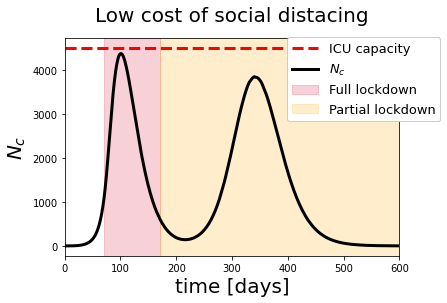

Deceased population: 20212


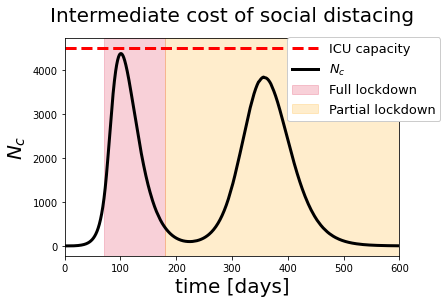

Deceased population: 31252


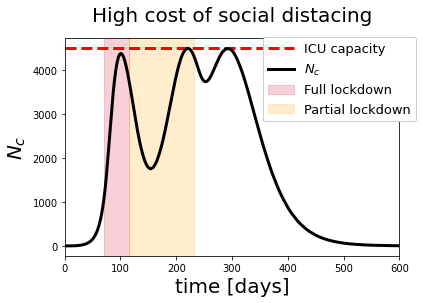

In [15]:
fontsize=20

labels = ['Low cost of social distacing',
          'Intermediate cost of social distacing',
          'High cost of social distacing']
for i,e in enumerate(list_of_trajectories[0]):
    #
    cost, t_arr, traj, events_occured = e
    print('Deceased population: {0:3.0f}'.format(np.sum(traj[7*M:8*M,-1],axis=0)))
    #
    for j,e in enumerate(events_occured):
        #print(e)
        if e[1] == 1:
            lockdown_start = e[0] 
        if e[1] == 2:
            lockdown_release_1 = e[0]
        if e[1] == 3:
            lockdown_release_2 = e[0]
    #
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.set_title(labels[i],fontsize=20,y=1.05)
    ax.axhline(4500,label='ICU capacity',color='red',lw=3,
              ls='--')
    ax.axvspan(lockdown_start,lockdown_release_1,
               label='Full lockdown',
              alpha=0.2,color='crimson')
    ax.axvspan(lockdown_release_1,lockdown_release_2,
                              label='Partial lockdown',
              alpha=0.2,color='orange')
    ax.plot(t_arr,np.sum(traj[6*M:7*M],axis=0),
            label=r'$N_c$',
            color='black',
            lw=3,
           )
    ax.set_xlim(0,600)
    if i  <2:
        ax.legend(loc='upper right',bbox_to_anchor=(1.142,1.0345),
                  fontsize=13,framealpha=1.)
    elif i == 2:
        ax.legend(loc='upper right',bbox_to_anchor=(1.07,1.0343),
                  fontsize=13,framealpha=1.)
    else:
        ax.legend(loc='best',fontsize=13,framealpha=1.)
    ax.set_xlabel('time [days]',fontsize=fontsize)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    plt.show()
    #fig.savefig('optimal_protocol_{0}.png'.format(i),bbox_inches='tight',dpi=100)
    #fig.savefig('optimal_protocol_{0}.jpg'.format(i),bbox_inches='tight',dpi=200)
    plt.close()